In [1]:
import pandas as pd
import numpy as np
import scanpy as sc

import matplotlib.pyplot as plt
import seaborn as sns

from anticor_features.anticor_features import get_anti_cor_genes
import topo as tp
from topo.tpgraph.intrinsic_dim import IntrinsicDim

In [2]:
import datetime
print(datetime.datetime.now().isoformat())

2025-02-26T14:27:59.582581


In [3]:
raw = pd.read_csv('./data/schmidtea/dge.txt.gz', sep='\t', index_col=0)

In [4]:
adata = sc.AnnData(raw.T)

In [5]:
meta = pd.read_csv('./data/schmidtea/Planaria_Seurat_annot.csv', index_col=0)

In [6]:
adata.obs = adata.obs.join(meta)

In [7]:
adata.write_h5ad('./data/schmidtea/schmidtea.h5ad')

In [8]:
# PFlogPF normalisation
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.normalize_total(adata)

In [9]:
anti_cor_table = get_anti_cor_genes(adata.X.T,
                                    adata.var.index.tolist(),
                                    species="",
                                    pre_remove_pathways=[])

selected_table = anti_cor_table[anti_cor_table["selected"]==True]

found 761.168285696 free Gb in /var/folders/md/d6lwwbv97xb6g6ddypntnprh0000gp/T
get_all_remove_genes
21612 1080
min_express_n 50
get_n_expressed
pre_remove_feature: 0
pre_remove_pathway: 0
pre_remove_low_express: 11368
11368  genes to remove out of  28065
rewriting the filtered dataset
/var/folders/md/d6lwwbv97xb6g6ddypntnprh0000gp/T/exprs.hdf5
total_vars: 16697
making the hdf5 spearman output file
/var/folders/md/d6lwwbv97xb6g6ddypntnprh0000gp/T/spearman.hdf5
get_the_spears
total_vars 16697
	getting spearman correlation


/opt/homebrew/Caskroom/mambaforge/base/envs/ascc24/lib/python3.9/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/homebrew/Caskroom/mambaforge/base/envs/ascc24/lib/python3.9/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


empirically determined Cneg cutoff: -0.01674876830405634  for FPR of: 0.001
empirically determined Cpos cutoff: 0.03840179582486208  for FPR of: 0.001
get_real_spear
[0, 5000, 10000, 15000, 16697]
working on 0 5000 vs 5000 10000
	getting spearman correlation
working on 0 5000 vs 10000 15000
	getting spearman correlation
working on 0 5000 vs 15000 16697
	getting spearman correlation
working on 5000 10000 vs 10000 15000
	getting spearman correlation
working on 5000 10000 vs 15000 16697
	getting spearman correlation
working on 10000 15000 vs 15000 16697
	getting spearman correlation


/opt/homebrew/Caskroom/mambaforge/base/envs/ascc24/lib/python3.9/site-packages/anticor_features/anticor_features.py:402: RuntimeWarning: divide by zero encountered in double_scalars
  FDR_vect[i] = FP_hat_vect[i]/all_sig_neg_vect[i]


In [10]:
adata.var = pd.concat([adata.var, anti_cor_table], axis=1)

# do some patching to the anti-correlated genes table
adata.var["highly_variable"] = adata.var["selected"].fillna(False)
adata.raw = adata

/var/folders/md/d6lwwbv97xb6g6ddypntnprh0000gp/T/ipykernel_87427/2695319484.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  adata.var["highly_variable"] = adata.var["selected"].fillna(False)


In [11]:
adata.uns["proposed_dimensionality"] = 25

sc.pp.scale(adata, max_value=10)
sc.pp.pca(adata, use_highly_variable=True)

sc.pp.neighbors(adata, n_neighbors=15, use_rep="X_pca", metric="cosine", n_pcs=adata.uns["proposed_dimensionality"])
sc.tl.umap(adata, min_dist=0.1)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [13]:
adata.obs

,nGene,nUMI,orig.ident,res.2,tree.ident,res.3,res.4,res.5,res.6,rough_Id,final_Id,time,run,cbc,New_CBC,color,tSNE1,tSNE2,col_hex
plan1_GACTTTCTCTTC,1691,8060,fix1,12,18,32,40,42,47,28,secretory 1,0.118699,plan1,GACTTTCTCTTC,IGACTTTCTCTTC,mediumpurple3,9.029341,0.954237,#8968CD
plan1_GTAAGGCGACAN,913,5490,fix1,12,18,32,40,42,47,28,secretory 1,0.116933,plan1,GTAAGGCGACAN,IGTAAGGCGACAN,mediumpurple3,8.978354,0.947395,#8968CD
plan1_TGGCCCAGCTGC,2241,8188,fix1,12,18,32,40,42,47,28,secretory 1,0.111728,plan1,TGGCCCAGCTGC,ITGGCCCAGCTGC,mediumpurple3,0.528594,12.984929,#8968CD
plan1_CTCCTGTAATTT,2488,7699,fix1,14,3,13,12,12,10,46,psap+ parenchymal cells,0.267832,plan1,CTCCTGTAATTT,ICTCCTGTAATTT,deeppink,-12.705068,-11.211578,#FF1493
plan1_ATGACGCATAAT,2318,7709,fix1,10,16,14,15,16,15,36,late epidermal progenitors 1,0.304501,plan1,ATGACGCATAAT,IATGACGCATAAT,#6BAED6,8.095386,-19.374706,#6BAED6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cutd3_TTTTCTATCTTT,210,285,reg day 4,25,44,28,39,43,44,50,psd+ cells,0.024366,cutd3,TTTTCTATCTTT,CTTTTCTATCTTT,darkolivegreen2,-1.065348,-9.585150,#BCEE68
cutd3_GCAGTTTTTGCG,666,1152,reg day 4,10,16,24,24,16,15,36,late epidermal progenitors 1,0.068656,cutd3,GCAGTTTTTGCG,CGCAGTTTTTGCG,#6BAED6,11.458495,-12.879634,#6BAED6
cutd3_CTGCGTTCATAC,213,288,reg day 4,1,36,1,2,7,35,2,neoblast 1,0.005005,cutd3,CTGCGTTCATAC,CCTGCGTTCATAC,grey80,-3.166246,1.205459,#CCCCCC
cutd3_GATAGCCCCTCT,247,350,reg day 4,3,37,6,20,27,61,6,neoblast 6,0.005170,cutd3,GATAGCCCCTCT,CGATAGCCCCTCT,#B8B8B8,-1.426831,0.401743,#B8B8B8


/opt/homebrew/Caskroom/mambaforge/base/envs/ascc24/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/homebrew/Caskroom/mambaforge/base/envs/ascc24/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


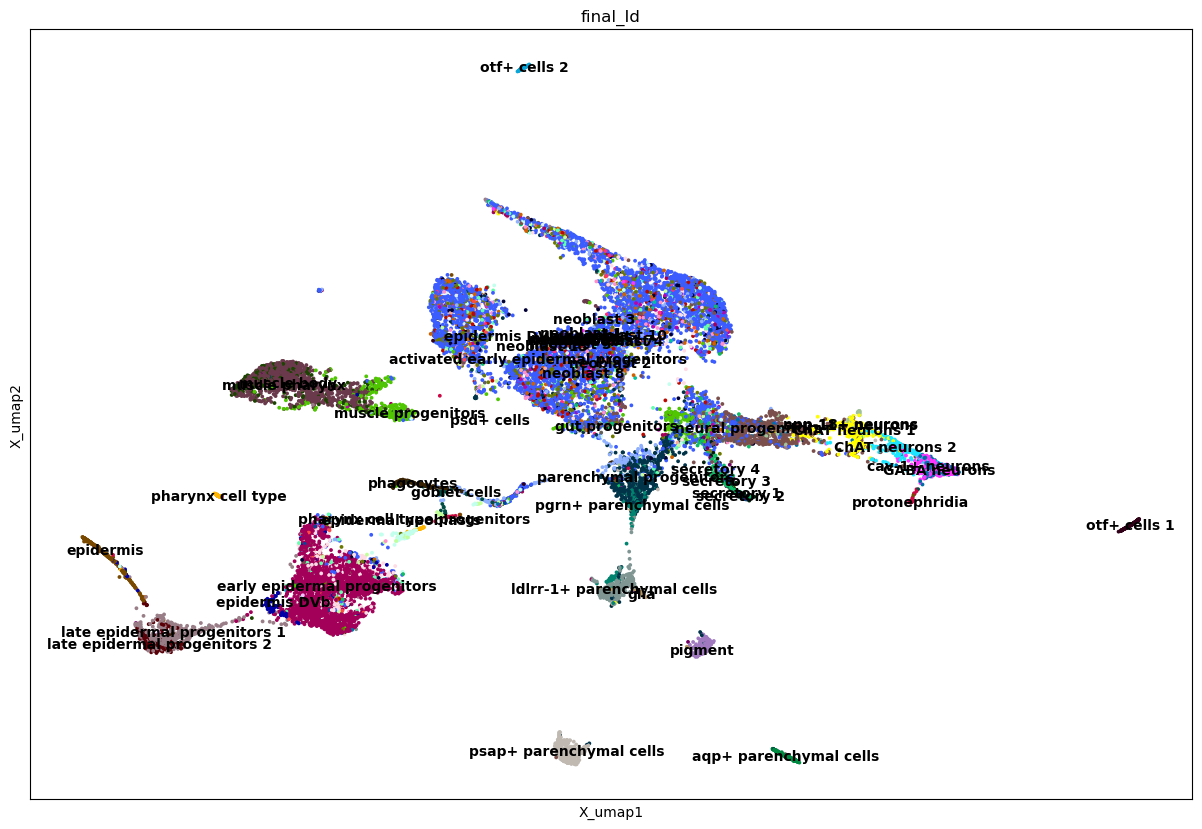

In [14]:
fig, ax = plt.subplots(figsize=(15, 10))
sc.pl.embedding(adata, basis="X_umap", color="final_Id", legend_loc="on data", ax=ax, s=30)